Run each cell and update the paths to the generated files accordingly. The last cell generates the caption for a given image using the trained model

(OR)

Use the pre-trained model, word map mentioned in the project report by updating their paths in the last cell along with the image path to generate and visualize a caption

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Create word_map**

In [ ]:
import json
import os

output_folder = '/content/drive/MyDrive/dl/project/out/'
captions_path = '/content/drive/MyDrive/dl/project/caption_datasets/dataset_flickr8k.json'

#keep track of word frequency
def count(word,freq):
    if word not in freq:
        freq[word] = 1
    else:
        freq[word] +=1  

#iterate through the dataset
def datacount(data,d):
    for i in data["images"]:
        for j in i['sentences']:
            for k in j['tokens']:
                count(k,d)

#creating wordmap
def wordmap(freq):
    wmap = {key:num+1 for num,key in list(enumerate(freq.keys()))}
    wmap['<unk>'] = len(freq)+1
    wmap['<start>'] = len(freq)+2
    wmap['<end>'] = len(freq)+3
    wmap['<pad>'] = 0
    return wmap

if __name__=='__main__':
        
    #load dataset
    with open(captions_path,"r") as file:
        data = json.load(file)
    freq = {}
    datacount(data,freq)
    #deleting entries with freq less than or equal to 5
    freq = {key:value for key, value in freq.items() if value>5}
    wmap = wordmap(freq)
    #save word map 
    with open(os.path.join(output_folder, 'WORDMAP.json'),'w') as file:
        json.dump(wmap,file)


**Create the image, captions and caption lengths input files from the flickr8k dataset**

In [ ]:
import numpy as np
import h5py
from skimage.transform import resize
from imageio import imread
import json
import os

dataset = 'flickr8k'
images_path = '/content/drive/MyDrive/dl/project/Flicker8k_Dataset/'

if __name__=='__main__':
    with open(captions_path,"r") as file:
        data = json.load(file)

    #lists to store captions
    test_cap = []
    test_path = []
    train_cap = []
    train_path=[]
    val_cap = []
    val_path = []    

    #add caption to lists
    for i in data['images']:
        captions = []
        if i['split'] == 'test':
            for j in i['sentences']:
                captions.append(j['tokens'])
            test_path.append(images_path+i['filename'])
        elif i['split'] == 'train': 
            for j in i['sentences']:
                train_cap.append(j['tokens'])
            train_path.append(images_path+i['filename'])
        else:
            for j in i['sentences']:
                val_cap.append(j['tokens'])
            val_path.append(images_path+i['filename'])

    #load wordmap
    with open(os.path.join(output_folder,"WORDMAP.json"),"r") as file:
        wmap = json.load(file)        

    #adding test caps
    test_caplen = []
    for i in range(len(test_cap)):
        test_caplen.append(len(test_cap[i]))
        test_cap[i] = [wmap['<start>']]+[wmap.get(a, wmap['<unk>']) for a in test_cap[i]]+[wmap['end']]+[wmap['<pad>']]*(50-len(test_cap[i]))        

    #adding train and val caps
    train_caplen = []
    for i in range(len(train_cap)):
        train_caplen.append(len(train_cap[i]))
        train_cap[i] = [wmap['<start>']]+[wmap.get(a, wmap['<unk>']) for a in train_cap[i]]+[wmap['end']]+[wmap['<pad>']]*(50-len(train_cap[i]))
    val_caplen = []
    for i in range(len(val_cap)):
        val_caplen.append(len(val_cap[i]))
        val_cap[i] = [wmap['<start>']]+[wmap.get(a, wmap['<unk>']) for a in val_cap[i]]+[wmap['end']]+[wmap['<pad>']]*(50-len(val_cap[i]))

    #save  
    with open(os.path.join(output_folder,'TEST_CAPTIONS_' + dataset + '.json'),'w') as file:
        json.dump(test_cap,file)
    with open(os.path.join(output_folder,'TEST_CAPLENS_' + dataset + '.json'),'w') as file:
        json.dump(test_caplen,file)
    with open(os.path.join(output_folder,'TRAIN_CAPTIONS_' + dataset + '.json'),'w') as file:
        json.dump(train_cap,file)
    with open(os.path.join(output_folder,'TRAIN_CAPLENS_' + dataset + '.json'),'w') as file:
        json.dump(train_caplen,file)
    with open(os.path.join(output_folder,'VAL_CAPTIONS_' + dataset + '.json'),'w') as file:
        json.dump(val_cap,file)
    with open(os.path.join(output_folder,'VAL_CAPLENS_' + dataset + '.json'),'w') as file:
        json.dump(val_caplen,file) 

    #image datasets
    #create the dataset
    
    #test data
    h5py.File(os.path.join(output_folder,'TEST_IMAGES_' + dataset + '.hdf5'), 'a').attrs['captions_per_image']=5
    imdata = h5py.File(os.path.join(output_folder,'TEST_IMAGES_' + dataset + '.hdf5'), 'a').create_dataset('images', (len(test_path), 3, 256, 256), dtype='uint8')
    #add images to dataset
    for i in range(len(test_path)):    
        img = imread(test_path[i])
        img = resize(img, (256, 256))
        img = img.transpose(2, 0, 1)
        # Save image to HDF5 file
        imdata[i] = img

    #train data
    h5py.File(os.path.join(output_folder,'TRAIN_IMAGES_' + dataset + '.hdf5'), 'a').attrs['captions_per_image']=5
    imdata = h5py.File(os.path.join(output_folder,'TRAIN_IMAGES_' + dataset + '.hdf5'), 'a').create_dataset('images', (len(train_path), 3, 256, 256), dtype='uint8')
    #add images to dataset
    for i in range(len(train_path)):    
        im = imread(train_path[i])
        im = resize(im, (256, 256))
        im = im.transpose(2, 0, 1)
        # Save image to HDF5 file
        imdata[i] = im

    #val data
    h5py.File(os.path.join(output_folder,'VAL_IMAGES_' + dataset + '.hdf5'), 'a').attrs['captions_per_image']=5
    imdata = h5py.File(os.path.join(output_folder,'VAL_IMAGES_' + dataset + '.hdf5'), 'a').create_dataset('images', (len(val_path), 3, 256, 256), dtype='uint8')
    #add images to dataset
    for i in range(len(val_path)):    
        im = imread(val_path[i])
        im = resize(im, (256, 256))
        im = im.transpose(2, 0, 1)
        # Save image to HDF5 file
        imdata[i] = im            

**Methods to save checkpoint, adjust learning rate etc which will be used during training**

In [ ]:
import os
import numpy as np
import h5py
import json
import torch
from skimage.transform import resize
from imageio import imread
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample


def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.

    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.

    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.

    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.

    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.data.size(0)
    _, ind = scores.data.topk(k, 1, True, True)
    correct = ind.eq(targets.data.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() * (100.0 / batch_size)


**Dataset class**

In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
import json
import os


class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']

        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size

**Pre-trained models, Encoder, Decoder, Attention models**

In [ ]:
from numpy.core.fromnumeric import mean
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class PreTrainedModels(object):

    """ 
    Pre-trained CNN models on ImageNet dataset and 1000 classes. For all the models, the final fully connected layer has been ignored as we just need the encoded image features.
    Models : ResNet, VGG, SqueezeNet
    Args: num_class (int): Number of classes in the dataset. 
    """

    def __init__(self,num_classes):
        self.num_classes = num_classes
        self.model = None
        self.input_size = None

    def set_parameter_requires_grad(self,model,feature_extraction): 

        """ 
        As we just need the features we set requires_grad = False for the parameters
        model : CNN models
        feature_extraction : True for feature extraction and False for fine-tuning 
        """

        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False

    def VGG(self,feature_extract = True): 
        
        """ 
        VGG19_bn
        feature_extract : True for feature extraction and False for fine-tuning
        Returns pretained VGG19_bn  model and it's expected input size
        """

        self.model = torchvision.models.vgg19_bn(pretrained=True) 
        self.set_parameter_requires_grad(self.model,feature_extract) 
        in_ftrs = self.model.classifier[6].in_features
        self.model = nn.Sequential(*list(self.model.children())[:-1]) 
        self.input_size = 512
        return self.model, self.input_size

    def SqueezeNet(self,feature_extract = True): 
        
        """ 
        Squeezenet
        feature_extract : True for feature extracking and False for fine-tuning
        Returns pretained Squeezenet model and it's expected input size
        """

        self.model = torchvision.models.squeezenet1_0(pretrained=True) 
        self.set_parameter_requires_grad(self.model,feature_extract)
        self.model.classifier[1] = nn.Conv2d(512, self.num_classes, kernel_size=(1,1), stride=(1,1)) 
        self.model = nn.Sequential(*list(self.model.children())[:-1]) 
        self.input_size = 224
        return self.model, self.input_size
    
    def ResNet(self,feature_extract = True): 

        """ 
        ResNet
        feature_extract : True for feature extraction and False for fine-tuning
        Returns pretained ResNet model and it's expected input size
        """

        self.model = torchvision.models.resnet152(pretrained=True) 
        self.set_parameter_requires_grad(self.model,feature_extract)
        in_ftrs = self.model.fc.in_features
        modules = list(self.model.children())[:-2]
        self.input_size = 224
        return self.model, self.input_size


class Encoder(nn.Module):
    """
    Encoder.
    """
    
    def __init__(self, model, in_size, embed_size, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        if model is not None:
            self.model = model
        else: # If no argument is given, Encoder uses ResNet pre-trained model
            resnet = torchvision.models.resnet101(pretrained=True)
            modules = list(resnet.children())[:-2]
            self.model = nn.Sequential(*modules)

        self.linear = nn.Linear(in_size, embed_size) 
        self.batchNorm = nn.BatchNorm2d(embed_size, momentum=0.01)

        # Resize image to fixed size to allow variable size input images
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()
        
    def forward(self, images):
        features = self.model(images)
        features = self.adaptive_pool(features)  # (batch_size, input_feature_size, encoded_image_size, encoded_image_size)
        features = features.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, input_feature_size)
        features = self.linear(features)
        features = features.permute(0, 3, 1, 2)  # (batch_size, input_feature_size, encoded_image_size, encoded_image_size)
        features = self.batchNorm(features)
        features = features.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, input_feature_size)
        return features

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.

        :param fine_tune: Allow?
        """
        for p in self.model.parameters():
            p.requires_grad = False
        # Fine-tune only the convolutional blocks 2 through 4
        for c in list(self.model.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) 
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        
        att1 = self.encoder_att(encoder_out) 
        att2 = self.decoder_att(decoder_hidden) 
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  
        alpha = self.softmax(att)  
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  
        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.init_weights()  # initialization of layers with uniform distribution
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding 
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention 
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # generate initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # generate initial cell state of LSTMCell
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # generate scores over vocabulary
        self.dropout = nn.Dropout(p=self.dropout)

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.

        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Fine-tuning of embedding layer 

        :param fine_tune: True for fine-tuning, False otherwise
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Generates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # As we don't decode when we generate <end> token
        decode_lengths = (caption_lengths - 1).tolist()

        # tensors to store word prediction scores and weights (alphas)
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind


**Model Training**

In [ ]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

# Data parameters
data_folder = '/content/drive/MyDrive/dl/project/out/'  # folder with data files saved by create_input_files.py
data_name = 'flickr8k'  # base name shared by data files

# Model parameters
emb_dim = 512  # word embeddings
attention_dim = 512  # attention linear layers
decoder_dim = 512  # decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for the model and tensors
cudnn.benchmark = True 

# Training parameters
start_epoch = 0
epochs = 2  # number of epochs to train for
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU score
batch_size = 32
workers = 0  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # Cuurent best BLEU-4 score
print_freq = 100  # print training/validation stats every 'print_freq' batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none


def main():
    """
    Training and validation.
    """

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    # Initialize / load checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim, embed_dim=emb_dim, decoder_dim=decoder_dim, vocab_size=len(word_map), dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)
        
        LATENT_SPACE = 300

        model, input_size = PreTrainedModels(LATENT_SPACE).VGG()
        encoder = Encoder(model, input_size, emb_dim)
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    for epoch in range(start_epoch, epochs):

        # Gradual decay of learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # Epoch's training
        train(train_loader=train_loader, encoder=encoder, decoder=decoder, criterion=criterion, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, epoch=epoch)

        # Epoch's validation
        recent_bleu4 = validate(val_loader=val_loader, encoder=encoder, decoder=decoder, criterion=criterion)

        # Check for improvement
        best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # total time for a batch (forward + back propagation)
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward propagation
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads using pack_padded_sequence
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Loss calculation
        loss = criterion(scores.data, targets.data)

        # Doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back propagation
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):
    """
    Performs a single epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # true captions for calculating BLEU-4 score
    hypotheses = list()  # predictions

    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to GPU, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward propagation
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads using pack_padded_sequence
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Loss Calculation
            loss = criterion(scores.data, targets.data)

            # Doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time, loss=losses, top5=top5accs))

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu4_1 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))


        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-1 - {bleu1}, BLEU-2 - {bleu2}, BLEU-3 - {bleu3}, BLEU-4 - {bleu4_1}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu1 = bleu1,
                bleu2 = bleu2,
                bleu3 = bleu3,
                bleu4_1=bleu4_1))

    return bleu4


if __name__ == '__main__':
    main()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Epoch: [0][0/938]	Batch Time 17.745 (17.745)	Data Load Time 11.012 (11.012)	Loss 8.7660 (8.7660)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/938]	Batch Time 0.691 (0.921)	Data Load Time 0.068 (0.239)	Loss 5.6962 (6.3912)	Top-5 Accuracy 37.500 (31.237)
Epoch: [0][200/938]	Batch Time 0.690 (0.809)	Data Load Time 0.063 (0.153)	Loss 5.3594 (5.9296)	Top-5 Accuracy 43.770 (36.671)
Epoch: [0][300/938]	Batch Time 0.706 (0.770)	Data Load Time 0.058 (0.123)	Loss 4.9534 (5.6656)	Top-5 Accuracy 50.000 (40.309)
Epoch: [0][400/938]	Batch Time 0.693 (0.750)	Data Load Time 0.065 (0.108)	Loss 4.7921 (5.4885)	Top-5 Accuracy 52.201 (42.689)
Epoch: [0][500/938]	Batch Time 0.708 (0.738)	Data Load Time 0.062 (0.098)	Loss 4.7849 (5.3660)	Top-5 Accuracy 51.724 (44.310)
Epoch: [0][600/938]	Batch Time 0.709 (0.730)	Data Load Time 0.060 (0.092)	Loss 4.8049 (5.2701)	Top-5 Accuracy 50.829 (45.680)
Epoch: [0][700/938]	Batch Time 0.672 (0.724)	Data Load Time 0.059 (0.088)	Loss 4.6400 (5.1864)	Top-5 Accuracy 55.446 (

**Caption Generator**

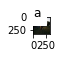

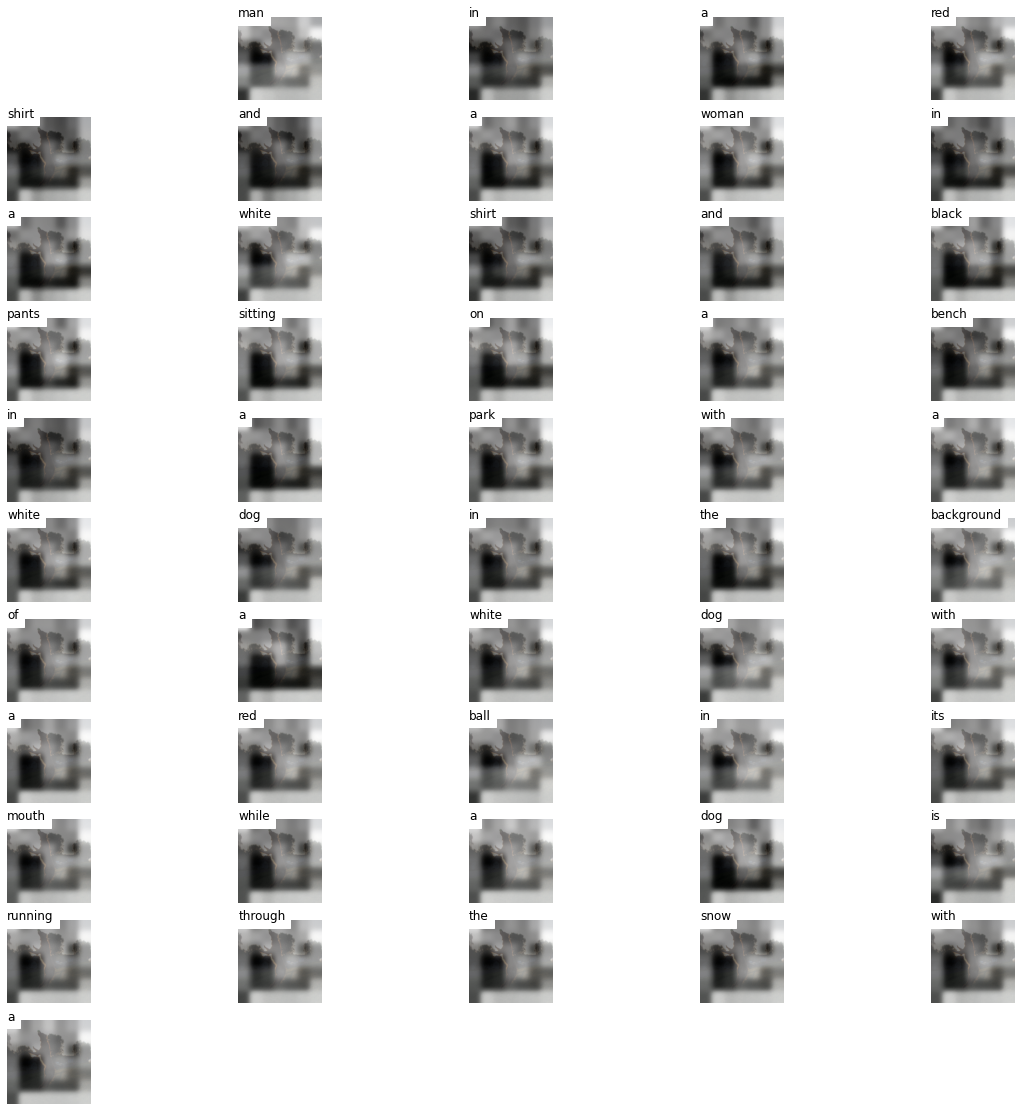

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from skimage.transform import resize
from imageio import imread
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def caption_image(encoder, decoder, image_path, word_map):
    """
    Reads an image and captions it

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :return: caption, weights for visualization
    """

    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = resize(img, (512, 512))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img) 

    # Encode
    image = image.unsqueeze(0)
    encoder_out = encoder(image) 
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim) 
    num_pixels = encoder_out.size(1)

    encoder_out = encoder_out.expand(1, num_pixels, encoder_dim) 

    # Tensor to store the previous word; now it just has <start> token
    prev_word = torch.LongTensor([[word_map['<start>']]] * 1).to(device) 

    seqs = list()
    seqs_alpha = list()

    # decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)
 
    while True:

        embeddings = decoder.embedding(prev_word).squeeze(1)  # (batch_size, max_caption_length, embed_dim)
        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (1, enc_image_size, enc_image_size)
        gate = decoder.sigmoid(decoder.f_beta(h))  # (batch_size_t, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding
        h, c = decoder.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1),(h, c))  # (batch_size_t, decoder_dim)
        preds = decoder.fc(decoder.dropout(h))  # (batch_size_t, vocab_size)
        preds = F.log_softmax(preds, dim=1)
        
        if step == 1:
            top_score, top_word = preds[0].topk(1, 0, True, True)
        else:
            # find the best score and their index
            top_score, top_word = preds.view(-1).topk(1, 0, True, True) 

        if (top_word.item() == word_map['<end>']):
            break

        seqs.append(top_word)
        seqs_alpha.append(alpha)

        prev_word = top_word

        if step > 50:
            break
        step += 1

    return seqs, seqs_alpha


def visualize_att(image_path, sequence, alphas, reverse_wordmap, smooth=True):
    """
    Visualizes caption with weights for every word.

    Adapted from repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    image_path: path to image that has been captioned
    sequence: caption
    alphas: weights
    reverse_wordmap: reverse word mapping, i.e. ix2word
    smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind.item()] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t]
        current_alpha = current_alpha.detach()
        current_alpha = current_alpha.squeeze(0)

        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.cpu().numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.cpu().numpy(), [14 * 24, 14 * 24])

        if t == 0:
            plt.figure(figsize = (20,20))
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


if __name__ == '__main__':

    model = '/content/drive/MyDrive/dl/BEST_checkpoint_flickr8k.pth.tar'  # checkpoint of the trained model
    word_map = '/content/drive/MyDrive/dl/project/out/WORDMAP.json' 
    img = '/content/drive/MyDrive/dl/project/Flicker8k_Dataset/162743064_bb242faa31.jpg'
    smooth = 'smooth'

    checkpoint = torch.load(model, map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(word_map, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention
    seq, alphas = caption_image(encoder, decoder, img, word_map)

    # Visualize caption and attention of the best sequence
    visualize_att(img, seq, alphas, rev_word_map, smooth)
